In [26]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt

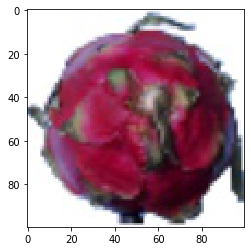

In [39]:
def load_dataset():
    data_path = '../data/fruits-360/Training'
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.ToTensor()
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=64,
        num_workers=0,
        shuffle=True
    )
    return train_loader

data_loader = load_dataset()

for batch_idx, (inputs, _) in enumerate(data_loader):
    img = inputs[0]
    img = img.permute(1, 2, 0)
    plt.figure()
    plt.imshow(img.numpy())
    plt.show()
    if batch_idx==0:
        break

In [3]:
batch_size = 128
epochs = 100
log_interval = 10

In [4]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

In [6]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [7]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [8]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [9]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [10]:
import os
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                os.makedirs('results', exist_ok=True)
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [11]:
if __name__ == "__main__":
    for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       'results/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 547.808350
Train Epoch: 1 [1280/60000 (2%)]	Loss: 297.795227
Train Epoch: 1 [2560/60000 (4%)]	Loss: 240.371765
Train Epoch: 1 [3840/60000 (6%)]	Loss: 214.153946
Train Epoch: 1 [5120/60000 (9%)]	Loss: 219.745346
Train Epoch: 1 [6400/60000 (11%)]	Loss: 205.992203
Train Epoch: 1 [7680/60000 (13%)]	Loss: 205.311661
Train Epoch: 1 [8960/60000 (15%)]	Loss: 199.320007
Train Epoch: 1 [10240/60000 (17%)]	Loss: 186.728363
Train Epoch: 1 [11520/60000 (19%)]	Loss: 187.580490
Train Epoch: 1 [12800/60000 (21%)]	Loss: 180.957779
Train Epoch: 1 [14080/60000 (23%)]	Loss: 175.529739
Train Epoch: 1 [15360/60000 (26%)]	Loss: 174.957184
Train Epoch: 1 [16640/60000 (28%)]	Loss: 169.254272
Train Epoch: 1 [17920/60000 (30%)]	Loss: 164.214951
Train Epoch: 1 [19200/60000 (32%)]	Loss: 154.411285
Train Epoch: 1 [20480/60000 (34%)]	Loss: 163.279800
Train Epoch: 1 [21760/60000 (36%)]	Loss: 158.481216
Train Epoch: 1 [23040/60000 (38%)]	Loss: 152.797455
Train Epoch: 1 [24320/60000 